In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.preprocessing import label_binarize
from sklearn.manifold import TSNE

In [2]:
artworks_df = pd.read_csv('../01_artwork_clustering/omniart-post-artwork-clustering.csv')

In [3]:
centroids_df = pd.read_csv('../01_artwork_clustering/artwork-centroids.csv')

**1. Features**

In [4]:
artworks_df['cluster'] = 'cluster_' + artworks_df['cluster'].astype(str)

In [5]:
merged_df = pd.merge(artworks_df, centroids_df, left_on='cluster', right_on='name', how='left')

In [6]:
feature_columns = [col for col in centroids_df.columns if col != 'name']

In [7]:
data = merged_df[
    merged_df['decade'].notna() & (merged_df['decade'] != 2010) & (merged_df['decade'] != 2000)
].dropna(subset=feature_columns)

In [8]:
counts = data['decade'].value_counts()
decades_to_keep = counts[counts >= 2].index
data_filtered = data[data['decade'].isin(decades_to_keep)].copy()

In [9]:
X = data_filtered[feature_columns]

**2. Labels**

In [10]:
y = data_filtered['decade']

**3. Split dataset**

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

**4. Classify**

In [12]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)

In [13]:
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [14]:
y_pred = clf.predict(X_test)

**5. Evaluate**

In [15]:
print("Decade Classifier Accuracy: {:.2f}%".format(accuracy_score(y_test, y_pred) * 100))

Decade Classifier Accuracy: 9.10%


In [16]:
print(classification_report(y_test, y_pred, labels=y.unique(), zero_division=0))


              precision    recall  f1-score   support

        1360       0.00      0.00      0.00       102
        1750       0.14      0.12      0.13       301
        1640       0.00      0.00      0.00       408
        1720       0.00      0.00      0.00       240
        1730       0.00      0.00      0.00       151
        1460       0.00      0.00      0.00       245
        1870       0.05      0.01      0.01       790
        1440       0.00      0.00      0.00       200
        1470       0.00      0.00      0.00       339
        1830       0.11      0.01      0.02       246
        1540       0.00      0.00      0.00       156
        1670       0.00      0.00      0.00       394
        1790       0.06      0.01      0.01       372
        1740       0.00      0.00      0.00       163
        1550       0.00      0.00      0.00       244
        1560       0.00      0.00      0.00       248
        1610       0.00      0.00      0.00       297
        1590       0.00    

**4.1. Confusion matrix**

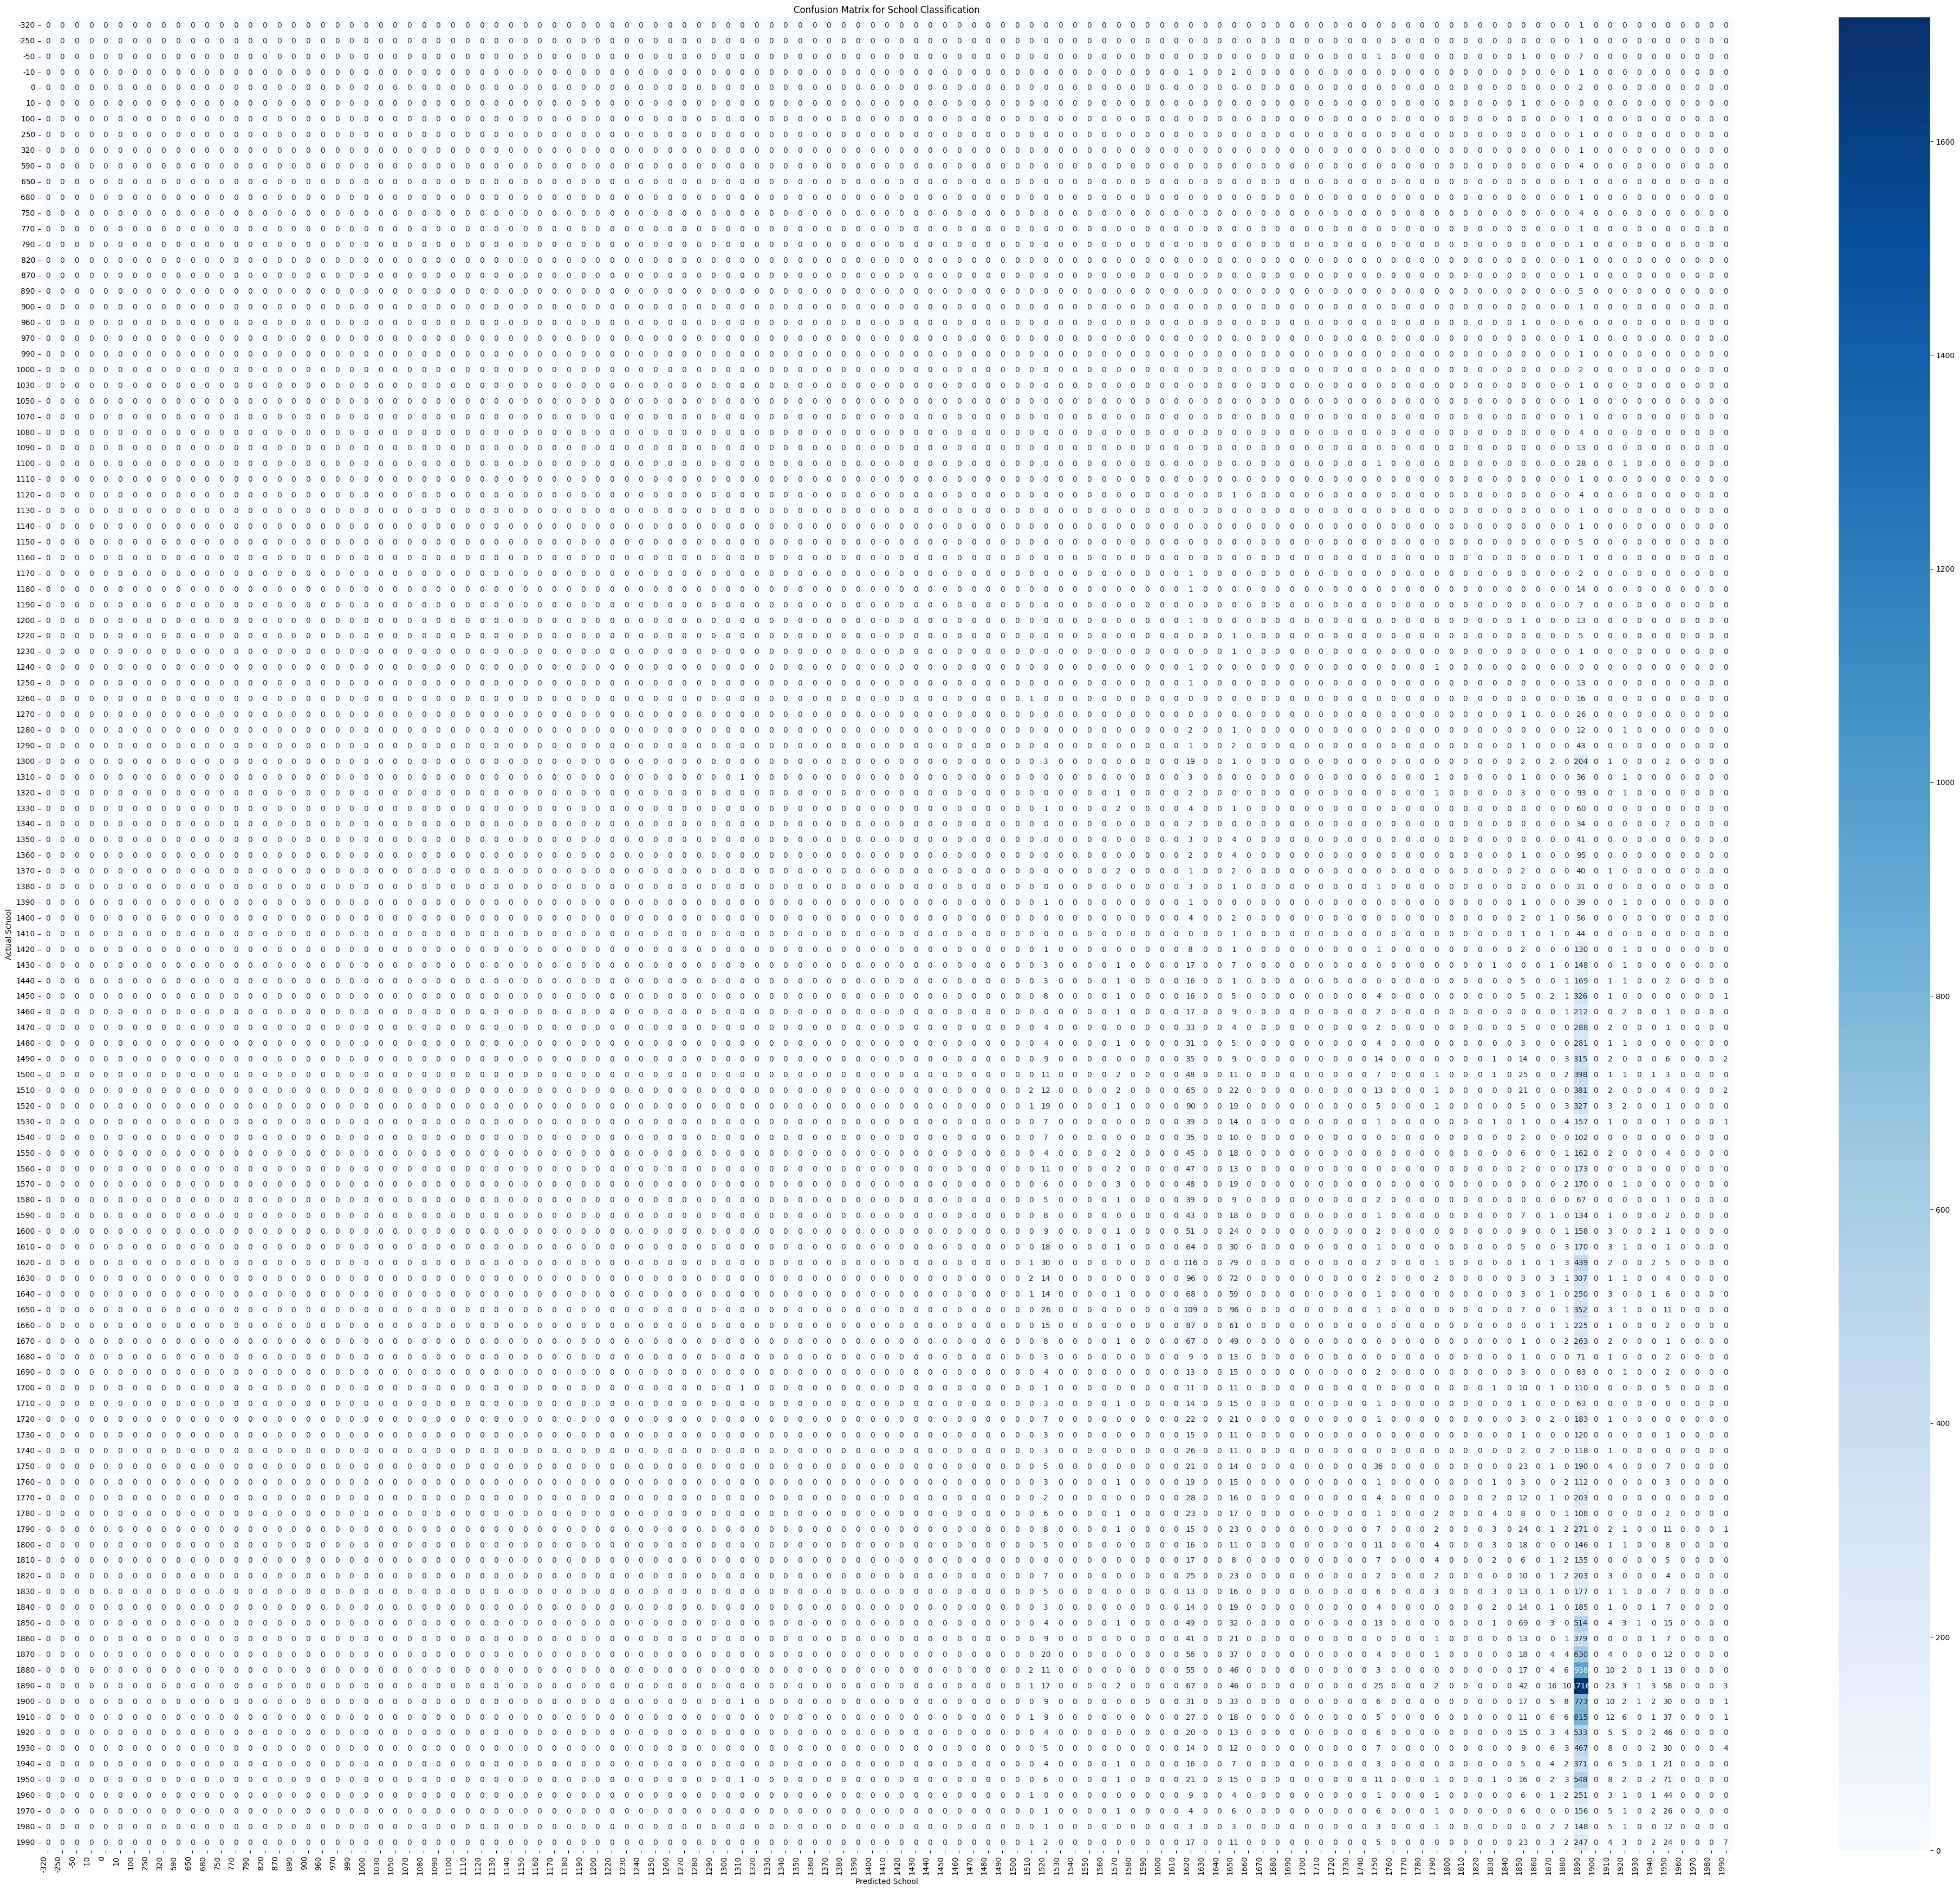

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

all_labels = clf.classes_

# Generate the confusion matrix for the school classifier
cm = confusion_matrix(y_test, y_pred, labels=all_labels)

# Plotting the confusion matrix
plt.figure(figsize=(40, 35))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=all_labels, yticklabels=all_labels)
plt.title('Confusion Matrix for School Classification')
plt.ylabel('Actual School')
plt.xlabel('Predicted School')
plt.xticks(rotation=90, ha='right')
plt.yticks(rotation=0)
plt.tight_layout() # Adjusts plot to prevent labels from overlapping
plt.show()

**4.2 Feature importance**

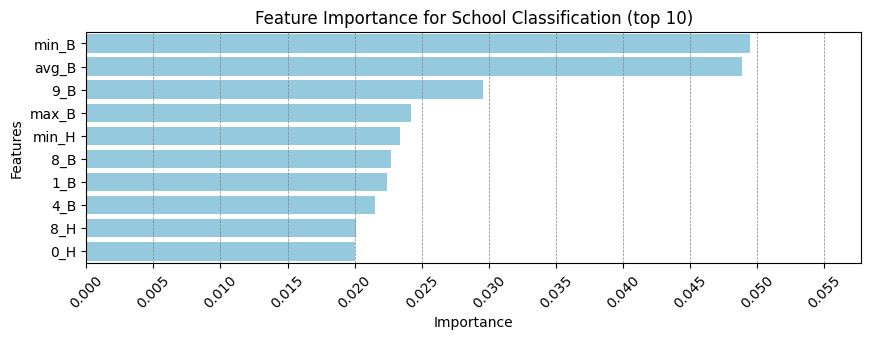

In [17]:
# For the school classifier (with balanced weights)
feature_importances_s = pd.DataFrame(clf.feature_importances_, 
                                     index = feature_columns, columns=['importance']
                                     ).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 3))
sns.barplot(x=feature_importances_s.importance, y=feature_importances_s.index, color='skyblue')

max_val = feature_importances_s.importance.max()
for x in np.arange(0, max_val + 0.01, 0.005):
    plt.axvline(x=x, color='gray', linestyle='--', linewidth=0.5)
x_ticks = np.arange(0, round(max_val + 0.01, 2), 0.005)
plt.xticks(x_ticks, [f'{tick:.3f}' for tick in x_ticks], rotation=45)
plt.title('Feature Importance for School Classification (top 10)')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.show()

**4.3. AUC value**

The **ROC (Receiver Operating Characteristic) curve** and the **AUC (Area Under the Curve)** are used to evaluate the performance of a **binary classifier**, particularly with respect to **discrimination** — how well it separates positive and negative classes.

1. **What is the ROC Curve?**

The ROC curve plots:

* **True Positive Rate (TPR)** = Sensitivity = Recall =

  $$
  \frac{\text{True Positives}}{\text{True Positives + False Negatives}}
  $$
* **False Positive Rate (FPR)** =

  $$
  \frac{\text{False Positives}}{\text{False Positives + True Negatives}}
  $$

For **many thresholds** applied to predicted probabilities.


3. **What is AUC?**

The AUC is the **area under the ROC curve**, computed using numerical integration.

* AUC = 1 → Perfect classifier
* AUC = 0.5 → No discrimination (random)
* AUC < 0.5 → Worse than random

Mathematically:

If you have the ROC points $(FPR_1, TPR_1), (FPR_2, TPR_2), \ldots$, the AUC is calculated via the **trapezoidal rule**:

$$
\text{AUC} = \sum_{i=1}^{n-1} (FPR_{i+1} - FPR_i) \cdot \frac{TPR_{i+1} + TPR_i}{2}
$$

In [26]:
# Binarize the true labels to use in roc_curve
y_test_binarized = label_binarize(y_test, classes=range(len(all_labels)))
# Get the prediction probabilities for each class
y_score = clf.predict_proba(X_test)
n_classes = y_test_binarized.shape[1]

# Calculate the main confusion matrix to get TP/FP counts
cm = confusion_matrix(y_test, y_pred, labels=all_labels)
    
# Create a dictionary to map school names to their index for easy lookup
label_map = {label: i for i, label in enumerate(all_labels)}

auc_scores = dict()
tp_counts = dict()
fp_counts = dict()

for i, decade_name in enumerate(all_labels):
    fpr, tpr, _ = roc_curve(y_test_binarized[:, i], y_score[:, i])
    auc_scores[decade_name] = auc(fpr, tpr)
        
    # Get TP and FP from the confusion matrix
    tp_counts[decade_name] = cm[i, i]
    fp_counts[decade_name] = cm[:, i].sum() - cm[i, i]
        
# Create and display the table
auc_df = pd.DataFrame(list(auc_scores.items()), columns=['Decade', 'AUC Score'])
auc_df['True Positives'] = auc_df['Decade'].map(tp_counts)
auc_df['False Positives'] = auc_df['Decade'].map(fp_counts)
auc_df = auc_df.sort_values(by='AUC Score', ascending=False).reset_index(drop=True)

# Filter the DataFrame to include only rows where at least one TP or FP was recorded
filtered_auc_df = auc_df[(auc_df['True Positives'] > 0) | (auc_df['False Positives'] > 0)]
    
filtered_auc_df = filtered_auc_df.sort_values(by='AUC Score', ascending=False).reset_index(drop=True)
print("AUC Scores for decades with at least one True or False Positive:")
print(filtered_auc_df.to_string())

/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

AUC Scores for decades with at least one True or False Positive:
    Decade  AUC Score  True Positives  False Positives
0     1830   0.662088               3               24
1     1310        NaN               1                3
2     1510        NaN               2               12
3     1520        NaN              19              412
4     1570        NaN               3               34
5     1620        NaN             116             1998
6     1650        NaN              96             1155
7     1750        NaN              36              213
8     1790        NaN               2               32
9     1850        NaN              69              501
10    1870        NaN               4               81
11    1880        NaN               6               86
12    1890        NaN            1716            16383
13    1910        NaN              12              147
14    1920        NaN               5               51
15    1930        NaN               0                3


/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(
/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be mean

**4.4 t-SNE**

/Users/mulan/Library/Python/3.9/lib/python/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


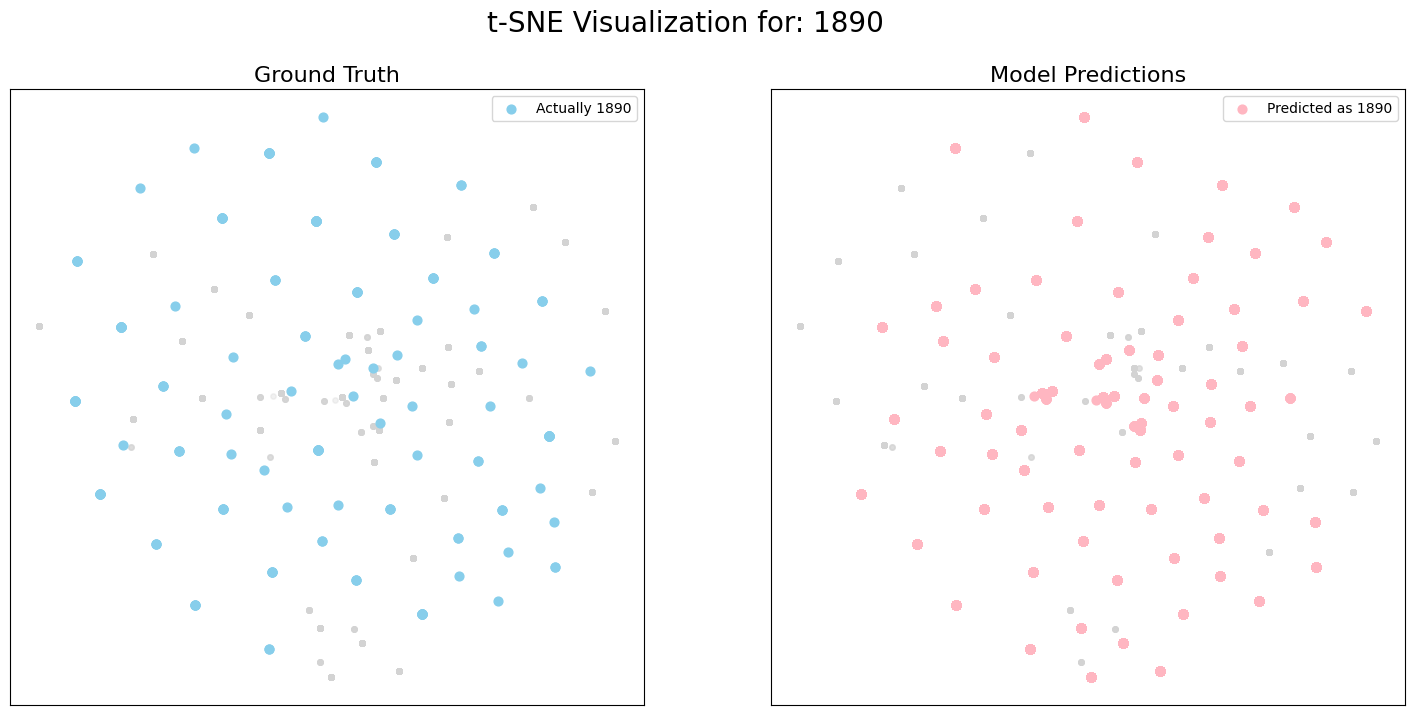

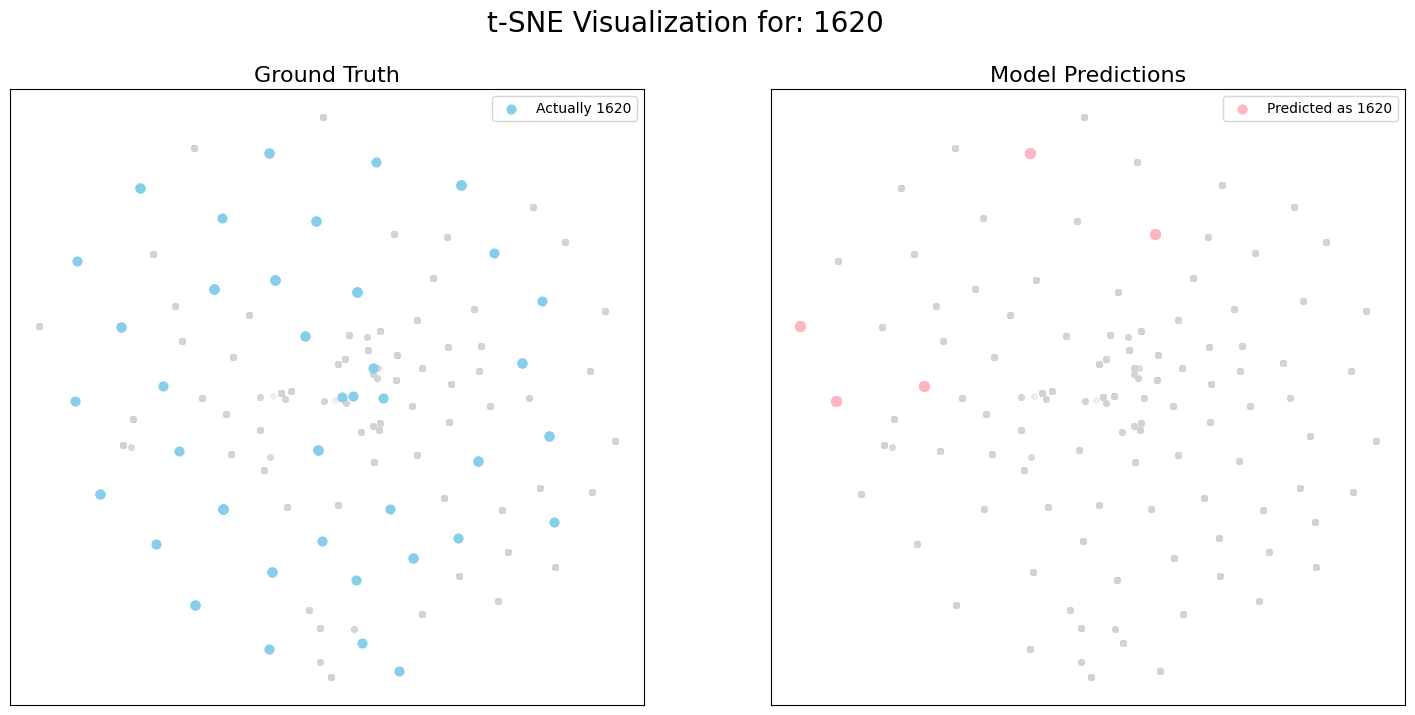

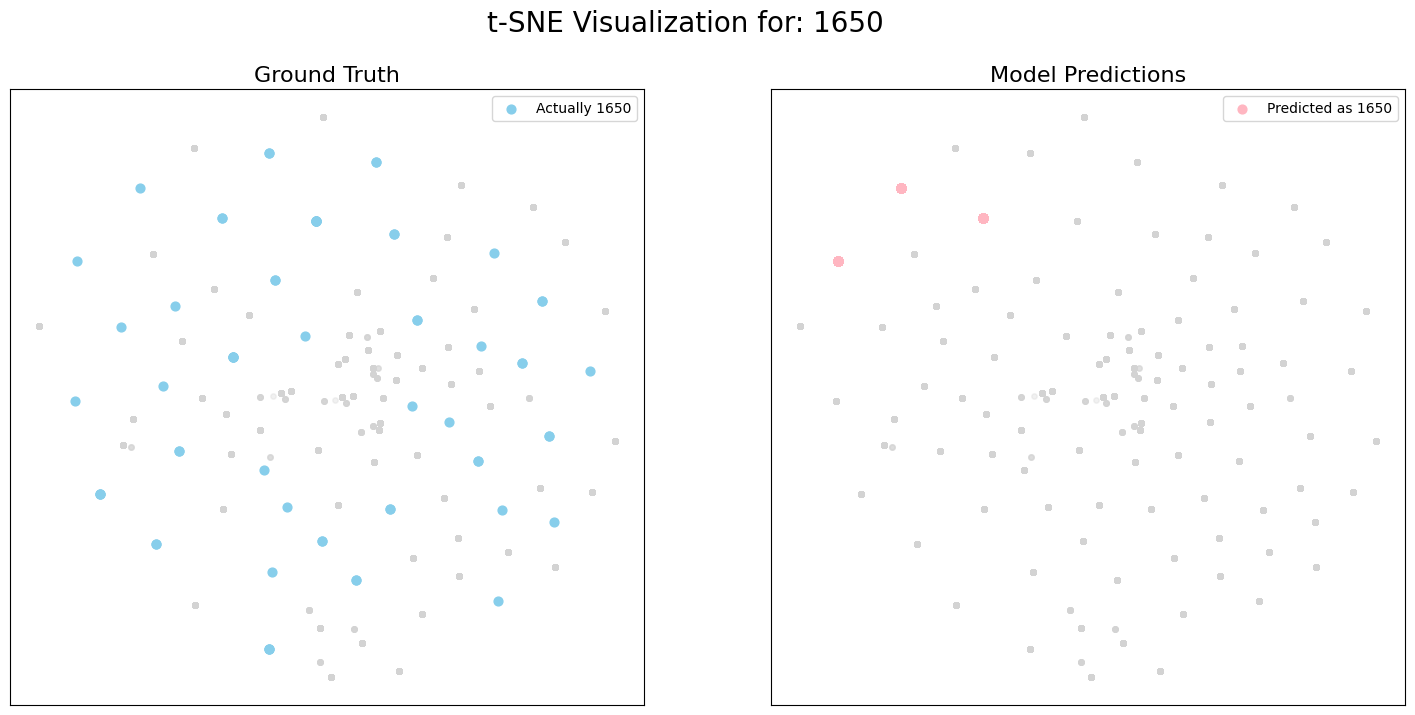

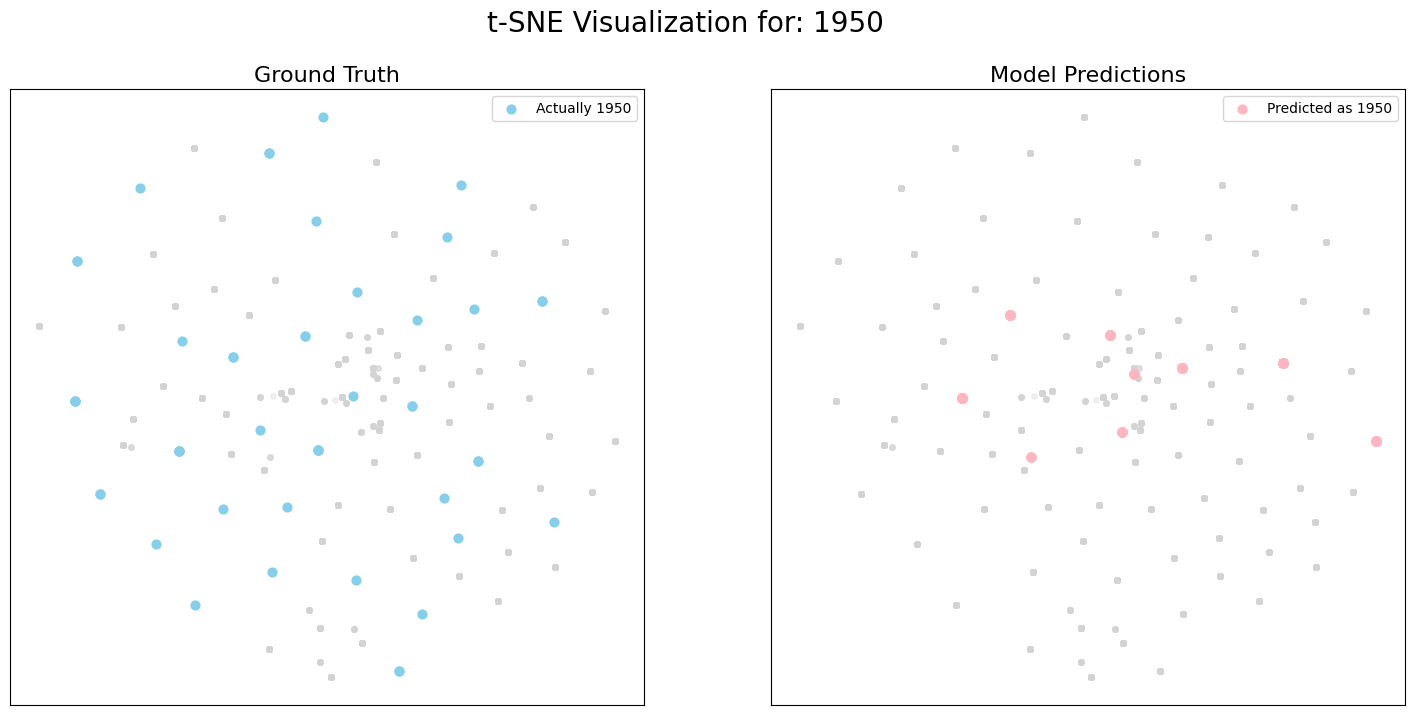

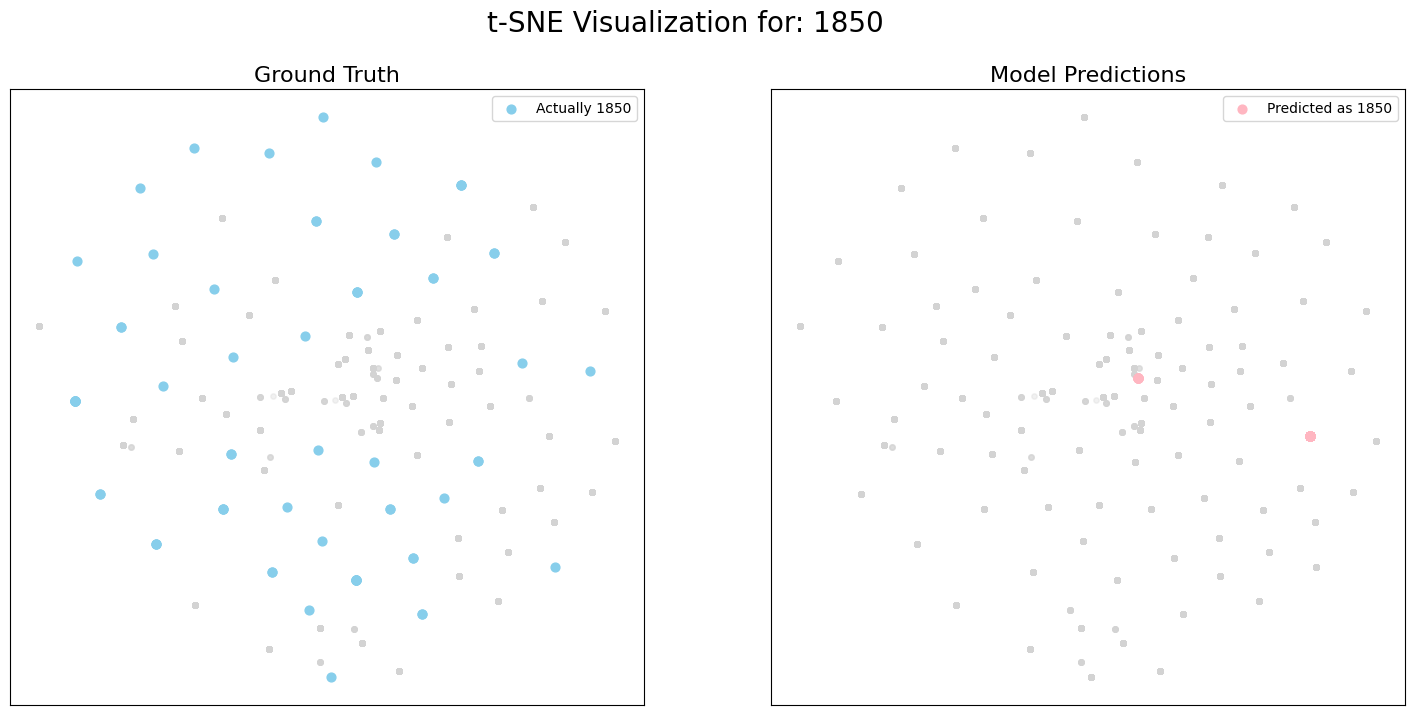

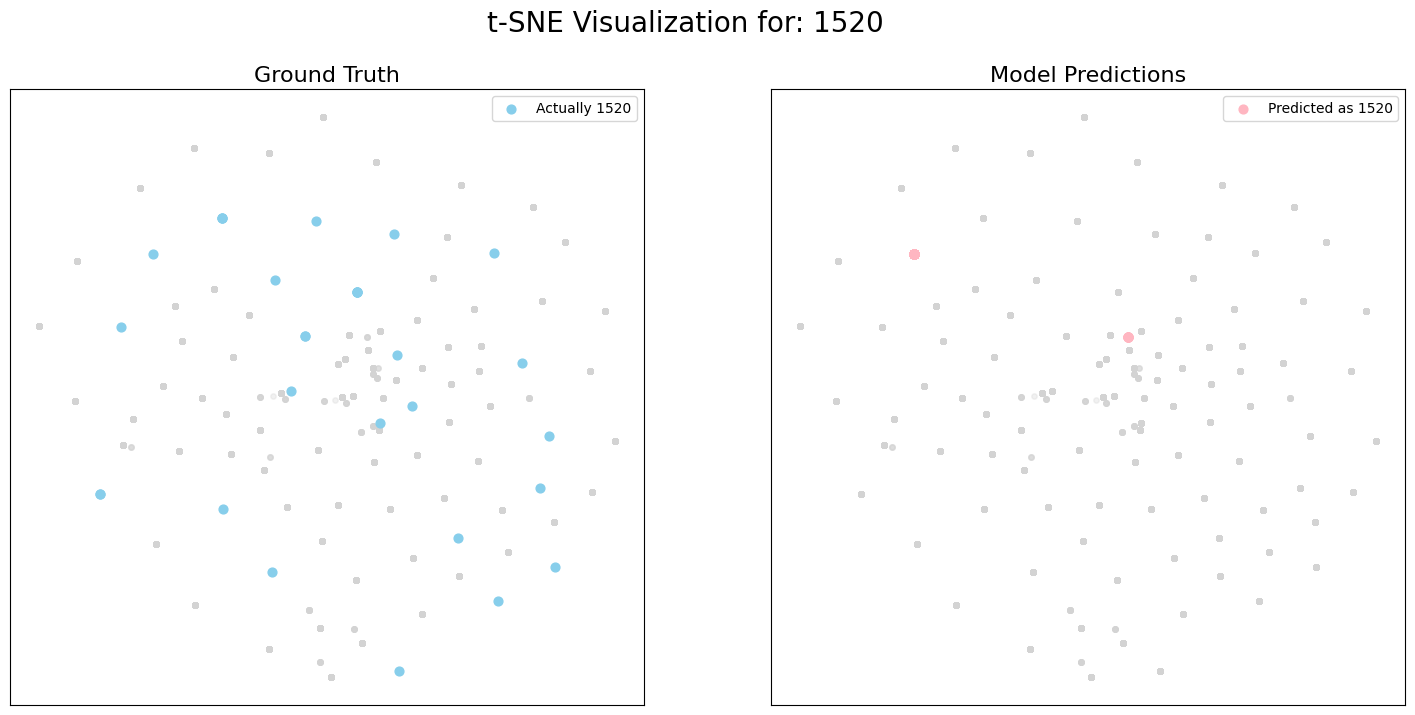

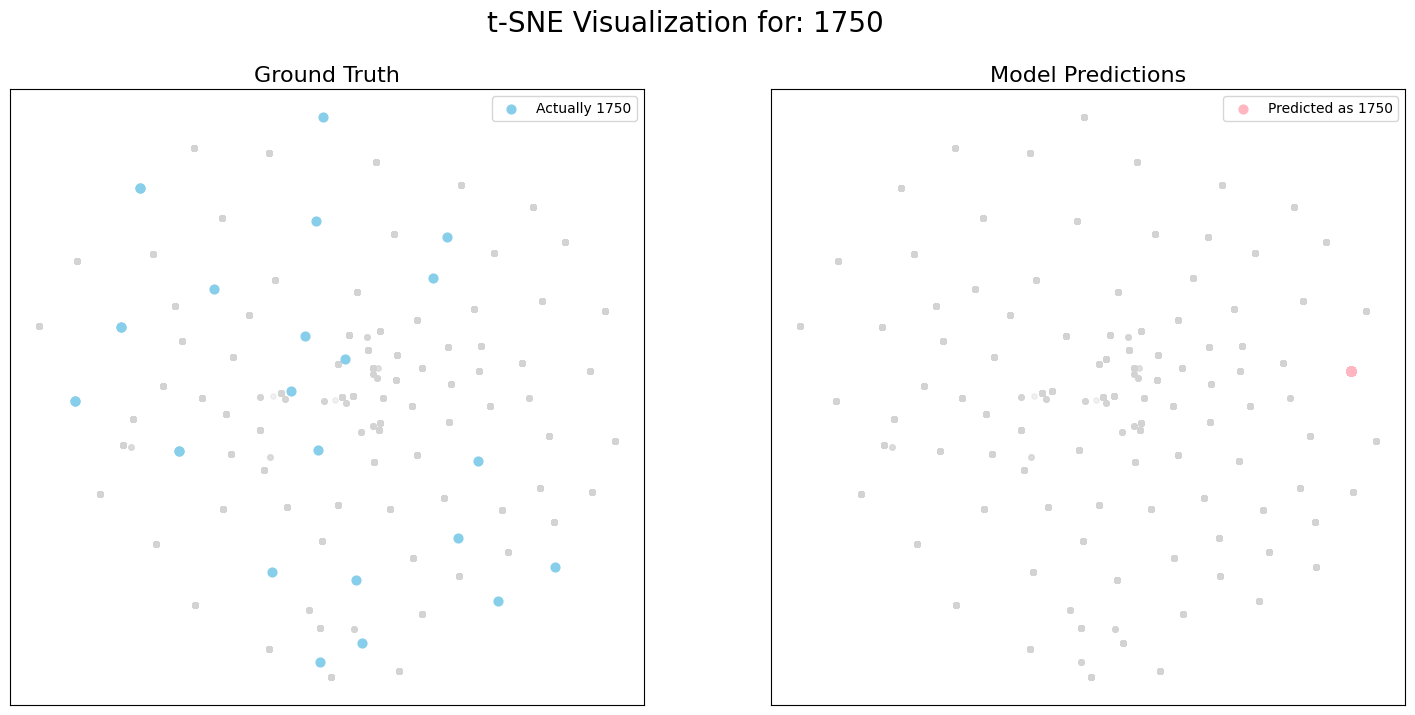

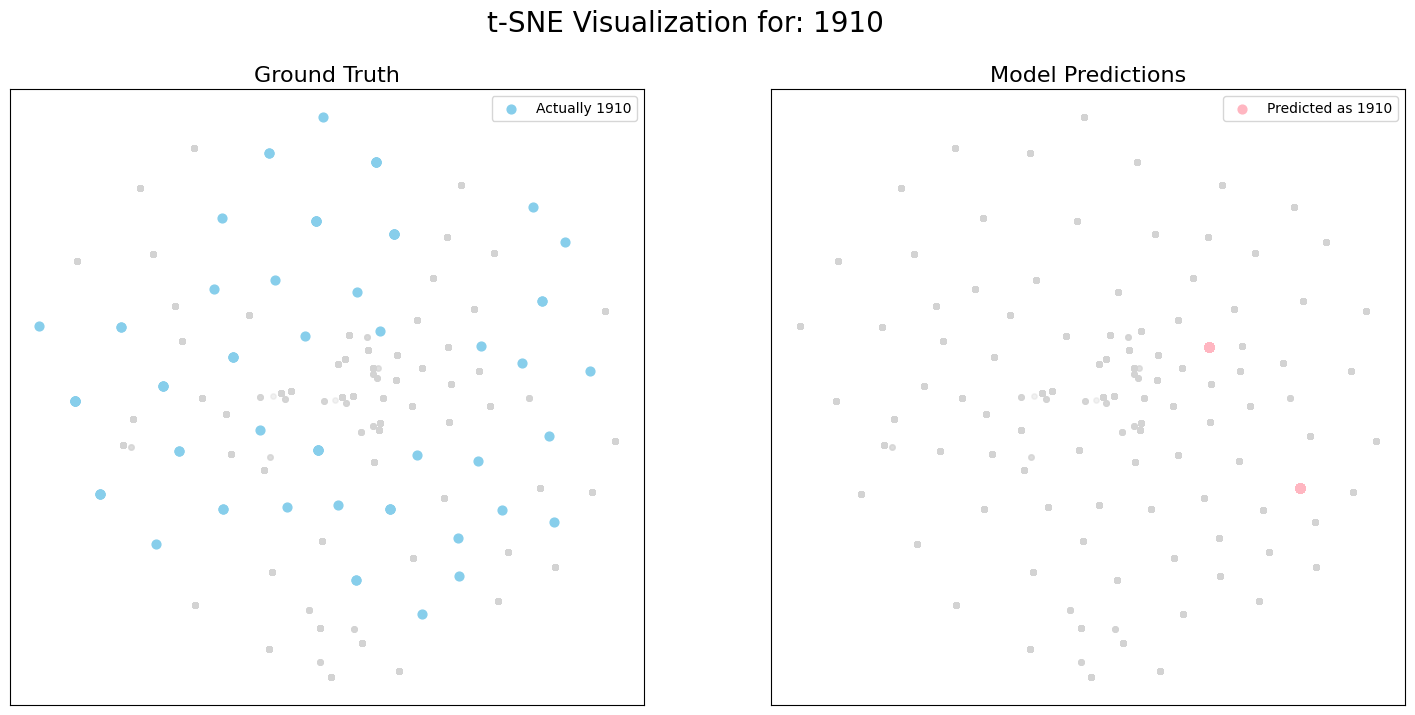

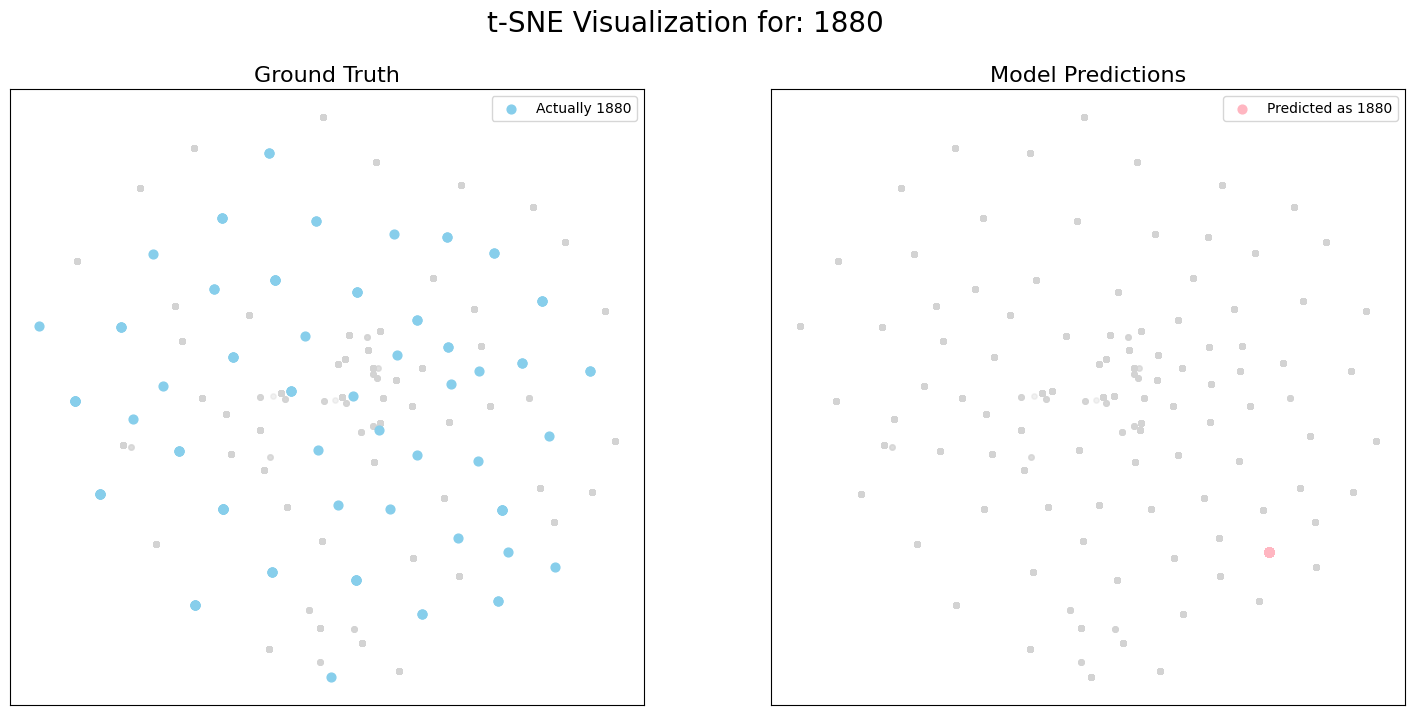

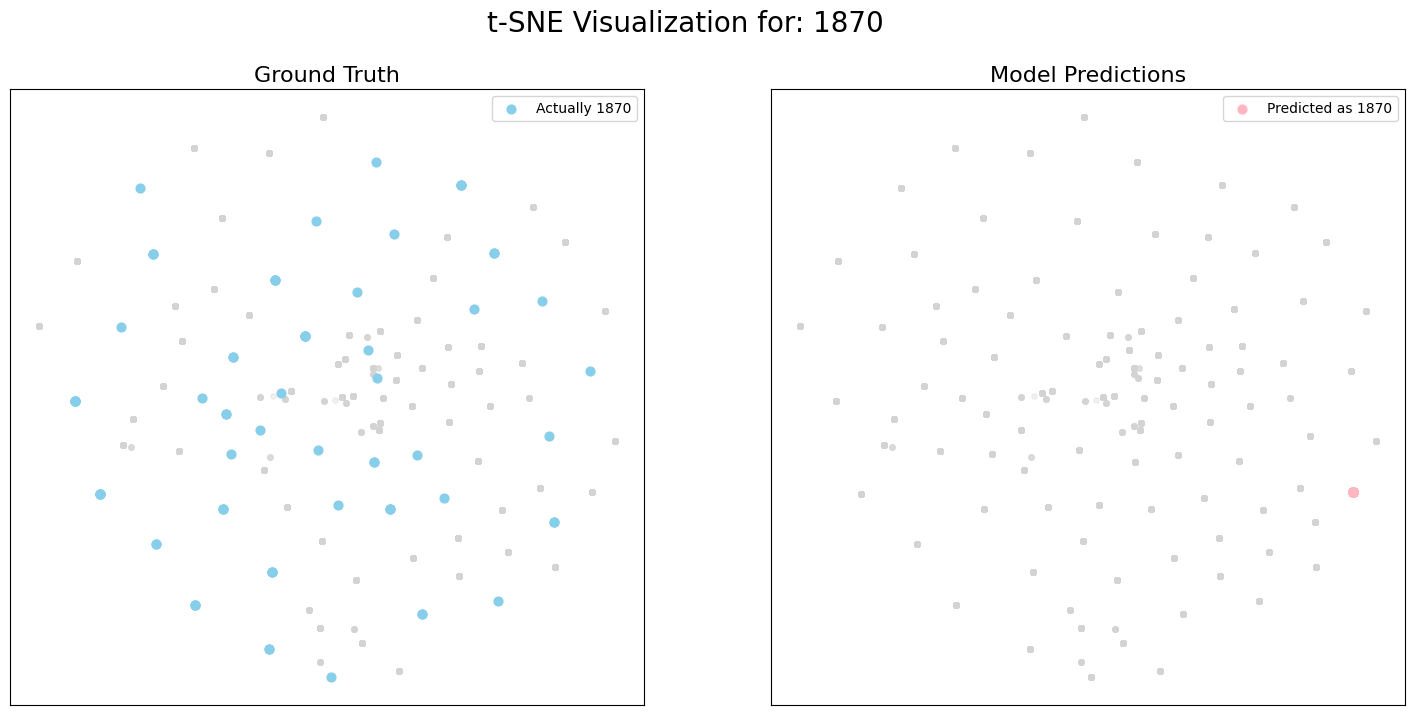

In [21]:
# Reduce dimensionality of the test features to 2D using t-SNE
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_test_2d = tsne.fit_transform(X_test)

# Create a DataFrame for plotting
plot_df = pd.DataFrame(X_test_2d, columns=['tsne1', 'tsne2'])
plot_df['true_school'] = y_test
plot_df['predicted_school'] = y_pred
    
# Identify the top 10 schools that actually got predictions
predicted_schools_counts = pd.Series(y_pred).value_counts()
top_10_predicted_schools = predicted_schools_counts.nlargest(10).index.tolist()

# Create a separate figure for each of the top 10 schools
for school in top_10_predicted_schools:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    fig.suptitle(f't-SNE Visualization for: {school}', fontsize=20)
        
    # --- Left Plot: Ground Truth ---
    ax1.set_title('Ground Truth', fontsize=16)
    # Plot all data points in a light gray as a background
    ax1.scatter(plot_df['tsne1'], plot_df['tsne2'], color='lightgray', s=15, alpha=0.3)
    # Highlight points where the TRUE school is the current one
    true_school_data = plot_df[plot_df['true_school'] == school]
    ax1.scatter(true_school_data['tsne1'], true_school_data['tsne2'], color='skyblue', s=40, label=f'Actually {school}')
    ax1.legend()
    ax1.set_xticks([])
    ax1.set_yticks([])

    # --- Right Plot: Model Predictions ---
    ax2.set_title('Model Predictions', fontsize=16)
    # Plot all data points in a light gray as a background
    ax2.scatter(plot_df['tsne1'], plot_df['tsne2'], color='lightgray', s=15, alpha=0.3)
    # Highlight points where the PREDICTED school is the current one
    predicted_as_school = plot_df[plot_df['predicted_school'] == school]
    ax2.scatter(predicted_as_school['tsne1'], predicted_as_school['tsne2'], color='lightpink', s=40, label=f'Predicted as {school}')
    ax2.legend()
    ax2.set_xticks([])
    ax2.set_yticks([])
        
    plt.show()

In [22]:
# Create a DataFrame of incorrect predictions
incorrect_predictions = X_test[y_test != y_pred].copy()
incorrect_predictions['true_school'] = y_test[y_test != y_pred]
incorrect_predictions['predicted_school'] = y_pred[y_test != y_pred]

print(f"\nNumber of incorrect predictions: {len(incorrect_predictions)}")
print("\nMost common misclassifications:")
print(incorrect_predictions.groupby(['true_school', 'predicted_school']).size().sort_values(ascending=False).head(20))


Number of incorrect predictions: 21677

Most common misclassifications:
true_school  predicted_school
1880         1890                938
1910         1890                815
1900         1890                773
1870         1890                630
1950         1890                548
1920         1890                533
1850         1890                514
1930         1890                467
1620         1890                439
1500         1890                398
1510         1890                381
1860         1890                379
1940         1890                371
1650         1890                352
1520         1890                327
1450         1890                326
1490         1890                315
1630         1890                307
1470         1890                288
1480         1890                281
dtype: int64
